# Przewidywanie zwycięzcy rundy w grze Counter Strike: Global Offensive

## Zmiany 26.05
- dodano rozdział "Optymalizacja hiperparametrów"
- dodano dodatkowe wykresy przedstawiające uzyskane wyniki w zależności od liczby epok

## Dane

Zbiór danych składa się ze snapshotów rund z około 700 meczów z profesjonalnych turniejów rozgrywanych w 2019 i 2020 roku.

Snapshoty - czyli zestawienie pewnych stanów kluczowych elementów rozgrywki - były rejestrowane podczas gry co 20 sekund aż do rozstrzygnięcia danej rundy. Łączna liczba zapisanych snapshotów wynosi 122411. Część tych rekordów będzie traktowana jako
zbiór danych uczących, a pozostała część jako część danych testów. Każdy rekord traktowany jest jako pojedynczy, niezależny element do analizy danych.

## Czym jest klasyfikator MLP?

Perceptron wielowarstwowy (MLP) to model sztucznej sieci neuronowej ze sprzężeniem do przodu, który odwzorowuje zestawy danych wejściowych na zestaw odpowiednich danych wyjściowych.

MLP składa się z wielu warstw, a każda warstwa jest w pełni połączona z następną. Węzły warstw to neurony z nieliniowymi funkcjami aktywacji, z wyjątkiem węzłów warstwy wejściowej. Pomiędzy warstwą wejściową a wyjściową może znajdować się jedna lub więcej nieliniowych warstw ukrytych.

## Import bibliotek i danych

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Data/csgo_round_snapshots.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


In [5]:
df.isnull().sum().sum()

0

In [6]:
df.shape

(122410, 97)

## Przeprocesowanie danych

W pierwszej koleności sprawdźmy liczność klas.

In [7]:
df['round_winner'].value_counts()

T     62406
CT    60004
Name: round_winner, dtype: int64

<AxesSubplot:xlabel='round_winner', ylabel='count'>

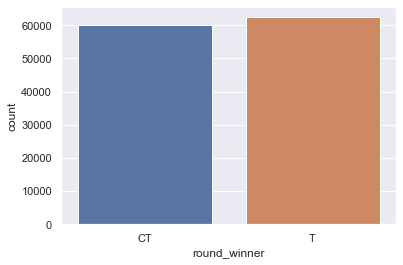

In [8]:
sns.set_theme(style="darkgrid")
sns.countplot(x='round_winner', data=df)

Następnie przekonwertujemy wszystkie kolumny na wartości liczbowe.

In [9]:
col = df.drop(df.select_dtypes(np.number), axis = 1).columns
col

Index(['map', 'bomb_planted', 'round_winner'], dtype='object')

In [10]:
lbl = LabelEncoder()
for value in col:
    df[value] = lbl.fit_transform(df[value])

In [11]:
df['bomb_planted'] = df['bomb_planted'].astype(np.int16)

In [12]:
cols = [f for f in df.columns if f not in ['round_winner']]

Dodatkowo każda wartość zostanie znormalizowana.

In [13]:
scaler = RobustScaler()

for value in cols:
    scaler = RobustScaler()
    df[value] = scaler.fit_transform(df[[value]])

Na koniec podzielimy dane na wektor danych oraz wektor wyników.

In [14]:
x = df.drop(['round_winner'], axis = 1)
y = df['round_winner']

In [15]:
len(cols)

96

Finalnie każdy rekord zawiera 96 atrybutów, które prezentują się w sposób przedstawiony poniżej.

In [16]:
x.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
0,0.715105,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,-1.291096,-1.136054,-0.112782,-0.191489,-0.5,-0.6,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
1,0.545726,-0.857143,-0.857143,-0.666667,0.0,0.000000,0.000000,0.078767,-0.115646,-0.368421,-0.395137,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
2,0.010000,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
3,-0.168575,-0.857143,-0.857143,-0.666667,0.0,-0.726667,-0.561798,-0.284247,-0.455782,-0.357143,-0.404255,-0.5,-0.6,0.000000,-1.0,-1.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0
4,0.714837,-0.714286,-0.857143,-0.666667,0.0,0.000000,0.000000,-0.633562,-1.136054,0.966165,0.218845,-0.5,-0.6,0.000000,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.333333,-0.333333,-0.333333,0.0,0.0,0.0,-0.5,0.0,0.0


### Wybór atrybutów

W pierwszej kolejności sprawdzimy, które atrybuty mają największy wpływ na klasy.

W tym celu wykorzystamy model *Random Forest Regressor*, który dopasowuje szereg klasyfikujących drzew decyzyjnych do różnych podpróbek zbioru danych i wykorzystuje uśrednianie w celu poprawy dokładności predykcyjnej i kontroli nadmiernego dopasowania.

In [17]:
rf = RandomForestRegressor(n_estimators=150, n_jobs=-1)
rf.fit(x, y)

RandomForestRegressor(n_estimators=150, n_jobs=-1)

Po stworzeniu i wyuczeniu modelu sortujemy tablice zawierającą informacje o tym, jak duży wpływ mają konkretne atrybuty w podejmowaniu decyzji.

In [18]:
indexes = rf.feature_importances_.argsort()

Wpływ poszczególnych atrybutów został przedstawiony na poniższym wykresie.

Text(0.5, 0, 'Feature Importance')

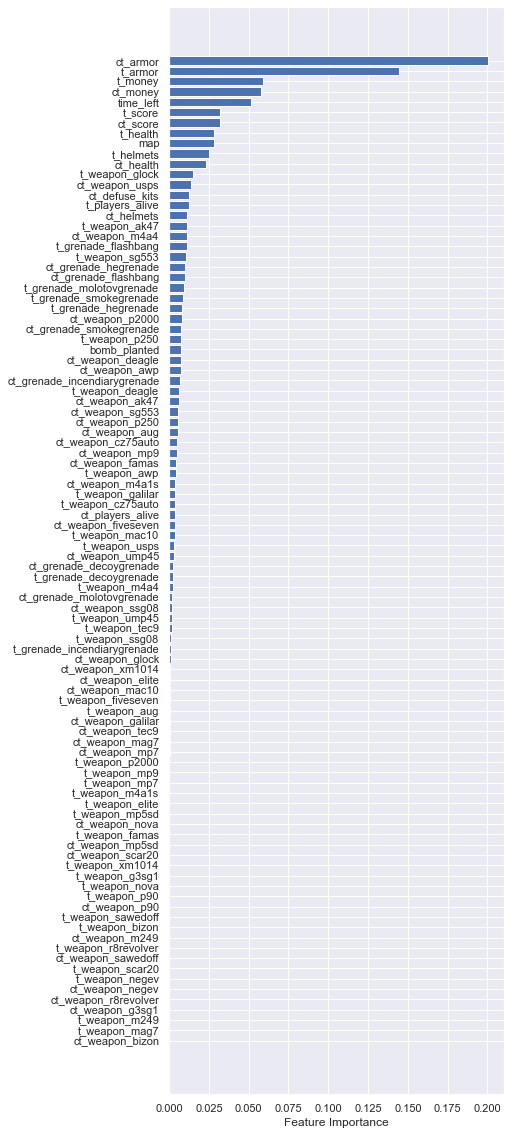

In [19]:
plt.figure(figsize=(6,20))
plt.barh(x.columns[indexes], rf.feature_importances_[indexes])
plt.xlabel("Feature Importance")

Następnie możemy odrzucić te atrybuty, które mają niski wpływ na podejmowanie decyzji lub nie mają żadnego. W tym celu wybraliśmy te atrybuty, dla których wartość parametru *feature_importance* jest większa od wartości 0,005.

In [20]:
importances = rf.feature_importances_[indexes]
indexes = indexes[np.argwhere(importances > 0.005)]
indexes = np.concatenate(indexes).ravel().tolist()
columns = x.columns[indexes]
x = x[columns]

W tym momencie możemy sprawdzić liczbę atrybutów pozostałych po selekcji.

In [21]:
x.shape

(122410, 38)

Mamy 38 atrybutów, które prezentują się jak w poniższej tabeli.

In [22]:
x.head()

,ct_weapon_cz75auto,ct_weapon_aug,ct_weapon_p250,ct_weapon_sg553,ct_weapon_ak47,t_weapon_deagle,ct_grenade_incendiarygrenade,ct_weapon_awp,ct_weapon_deagle,bomb_planted,t_weapon_p250,ct_grenade_smokegrenade,ct_weapon_p2000,t_grenade_hegrenade,t_grenade_smokegrenade,t_grenade_molotovgrenade,ct_grenade_flashbang,ct_grenade_hegrenade,t_weapon_sg553,t_grenade_flashbang,ct_weapon_m4a4,t_weapon_ak47,ct_helmets,t_players_alive,ct_defuse_kits,ct_weapon_usps,t_weapon_glock,ct_health,t_helmets,map,t_health,ct_score,t_score,time_left,ct_money,t_money,t_armor,ct_armor
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,-0.333333,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.857143,-0.857143,0.715105,-0.112782,-0.191489,-1.136054,-1.291096
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.857143,-0.857143,0.545726,-0.368421,-0.395137,-0.115646,0.078767
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,-1.0,0.000000,0.333333,0.000000,-0.726667,-0.6,-0.666667,-0.561798,-0.857143,-0.857143,0.010000,-0.357143,-0.404255,-0.455782,-0.284247
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,0.0,0.0,-0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,-1.0,0.000000,0.333333,-0.333333,-0.726667,-0.6,-0.666667,-0.561798,-0.857143,-0.857143,-0.168575,-0.357143,-0.404255,-0.455782,-0.284247
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,1.0,0.0,-0.333333,-0.5,-0.333333,0.0,0.0,-0.333333,-0.5,-0.5,-0.5,0.0,0.000000,0.333333,0.333333,0.000000,-0.6,-0.666667,0.000000,-0.714286,-0.857143,0.714837,0.966165,0.218845,-1.136054,-0.633562


Mając już przetworzone dane, możemy wydzielić z nich zbiór treningowy oraz testowy.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.1, random_state = 0)

In [24]:
x_train.shape

(110169, 38)

In [25]:
x_test.shape

(12241, 38)

Jak widać na podstawie powyższych wywołań, mamy 110169 rekordów w zbiorze testowym oraz 12241 w zbiorze treningowym. W tym momencie możemy rozpocząć inicjalizacje modelu.

### Model MLP

W celu inicjalizacji modelu zostanie wykorzystany klasyfikator MLP, zaimplementowany w bibliotece *scikit-learn* jako *MLPClassifier*.

*MLPClassifier* określa wielowarstwowy perceptron. W przeciwieństwie do innych algorytmów klasyfikacji, takich jak klasyfikator wektorów wspierających lub naiwny klasyfikator Bayesa, *MLPClassifier* przy wykonaniu zadania klasyfikacji opiera się na podstawowej sieci neuronowej.

Istotne cechy wielowarstwowego perceptronu MLP w bibliotece *scikit-learn*:
- w warstwie wyjściowej nie ma funkcji aktywacji,
- w przypadku scenariuszy regresji błąd kwadratowy jest funkcją straty, a entropia krzyżowa jest funkcją straty klasyfikacji,
- może pracować z regresją pojedynczych, jak i wielu wartości docelowych,
- w przeciwieństwie do innych popularnych pakietów, implementacja MLP w *scikit* nie obsługuje GPU.
- nie jest możliwe dostrojenie parametrów, takich jak różne funkcje aktywacji, inicjatory wagi itp. dla każdej warstwy.

In [26]:
nn_clf = MLPClassifier(verbose = True, warm_start=True, max_iter=1)

Opcja *verbose=True* powoduje, że na standardowe wyjście będą drukowane wiadomości o postępach w kolejnych iteracjach.

Ustawienie opcji *warm_start* na *True* oraz *max_iter* na *1* umożliwia zatrzymanie procesu uczenia na jednej epoce, dzięki czemu można będzie zobaczyć jak szybko uczy się model.

Następnie przechodzimy do dopasowania modelu do macierzy danych *x_train* i wyniku *y_train* dla dwustu epok, obliczając i zapamiętując wyniki dla zbioru treningowego i testowego.

In [27]:
scores_mlp_train = []
scores_mlp_test = []
for i in range(500):
    nn_clf.fit(x_train, y_train)
    scores_mlp_train.append(nn_clf.score(x_train, y_train))
    scores_mlp_test.append(nn_clf.score(x_test, y_test))
    print(f'Iteration {i + 1}, score = {nn_clf.score(x_test, y_test)}')

Iteration 1, loss = 0.48157134


C:\Users\Piotr\AppData\Local\pypoetry\Cache\virtualenvs\csgo-round-prediction-u_Zhvpzc-py3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, score = 0.754595212809411
Iteration 2, loss = 0.45486760
Iteration 2, score = 0.7578629196961033
Iteration 3, loss = 0.44854639
Iteration 3, score = 0.7617841679601339
Iteration 4, loss = 0.44418882
Iteration 4, score = 0.7642349481251531
Iteration 5, loss = 0.44089559
Iteration 5, score = 0.7653786455354955
Iteration 6, loss = 0.43858861
Iteration 6, score = 0.7639898701086513
Iteration 7, loss = 0.43676445
Iteration 7, score = 0.7697900498325301
Iteration 8, loss = 0.43479642
Iteration 8, score = 0.7688097377665224
Iteration 9, loss = 0.43296029
Iteration 9, score = 0.7677477330283473
Iteration 10, loss = 0.43159806
Iteration 10, score = 0.7722408299975492
Iteration 11, loss = 0.43009124
Iteration 11, score = 0.7711788252593742
Iteration 12, loss = 0.42904813
Iteration 12, score = 0.7715872886202108
Iteration 13, loss = 0.42796964
Iteration 13, score = 0.7700351278490319
Iteration 14, loss = 0.42688872
Iteration 14, score = 0.77191405930888
Iteration 15, loss = 0.4258964

Iteration 114, loss = 0.38674361
Iteration 114, score = 0.7859651989216567
Iteration 115, loss = 0.38641199
Iteration 115, score = 0.7884159790866759
Iteration 116, loss = 0.38638878
Iteration 116, score = 0.7850665795278163
Iteration 117, loss = 0.38606119
Iteration 117, score = 0.7884159790866759
Iteration 118, loss = 0.38618651
Iteration 118, score = 0.786291969610326
Iteration 119, loss = 0.38584438
Iteration 119, score = 0.7916019933012008
Iteration 120, loss = 0.38595982
Iteration 120, score = 0.7866187402989951
Iteration 121, loss = 0.38578331
Iteration 121, score = 0.7812270239359529
Iteration 122, loss = 0.38504369
Iteration 122, score = 0.7865370476268279
Iteration 123, loss = 0.38560268
Iteration 123, score = 0.791356915284699
Iteration 124, loss = 0.38497179
Iteration 124, score = 0.7884159790866759
Iteration 125, loss = 0.38486764
Iteration 125, score = 0.7872722816763337
Iteration 126, loss = 0.38478374
Iteration 126, score = 0.7907850665795279
Iteration 127, loss = 0.384

Iteration 224, loss = 0.37581052
Iteration 224, score = 0.7903766032186913
Iteration 225, loss = 0.37616559
Iteration 225, score = 0.7933992320888816
Iteration 226, loss = 0.37573949
Iteration 226, score = 0.7943795441548893
Iteration 227, loss = 0.37575304
Iteration 227, score = 0.7957683195817336
Iteration 228, loss = 0.37589377
Iteration 228, score = 0.7960133975982354
Iteration 229, loss = 0.37548178
Iteration 229, score = 0.7942161588105547
Iteration 230, loss = 0.37571085
Iteration 230, score = 0.7942161588105547
Iteration 231, loss = 0.37583548
Iteration 231, score = 0.7936443101053835
Iteration 232, loss = 0.37513475
Iteration 232, score = 0.7930724614002124
Iteration 233, loss = 0.37565997
Iteration 233, score = 0.7928273833837105
Iteration 234, loss = 0.37561653
Iteration 234, score = 0.7941344661383873
Iteration 235, loss = 0.37541278
Iteration 235, score = 0.7950330855322277
Iteration 236, loss = 0.37502828
Iteration 236, score = 0.790294910546524
Iteration 237, loss = 0.37

Iteration 328, score = 0.7920104566620374
Iteration 329, loss = 0.37075634
Iteration 329, score = 0.7923372273507067
Iteration 330, loss = 0.37151814
Iteration 330, score = 0.7969120169920758
Iteration 331, loss = 0.37159184
Iteration 331, score = 0.7912752226125317
Iteration 332, loss = 0.37109980
Iteration 332, score = 0.7907850665795279
Iteration 333, loss = 0.37098740
Iteration 333, score = 0.7976472510415815
Iteration 334, loss = 0.37139048
Iteration 334, score = 0.7934809247610489
Iteration 335, loss = 0.37077512
Iteration 335, score = 0.7959317049260681
Iteration 336, loss = 0.37094601
Iteration 336, score = 0.79405277346622
Iteration 337, loss = 0.37076019
Iteration 337, score = 0.7935626174332162
Iteration 338, loss = 0.37119384
Iteration 338, score = 0.795114778204395
Iteration 339, loss = 0.37122741
Iteration 339, score = 0.791356915284699
Iteration 340, loss = 0.37085988
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 340,

Iteration 420, loss = 0.36868564
Iteration 420, score = 0.795359856220897
Iteration 421, loss = 0.36899648
Iteration 421, score = 0.7947880075157259
Iteration 422, loss = 0.36899578
Iteration 422, score = 0.7970754023364104
Iteration 423, loss = 0.36859719
Iteration 423, score = 0.7965035536312393
Iteration 424, loss = 0.36890486
Iteration 424, score = 0.7957683195817336
Iteration 425, loss = 0.36892741
Iteration 425, score = 0.7956049342373989
Iteration 426, loss = 0.36886930
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 426, score = 0.794297851482722
Iteration 427, loss = 0.36929016
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 427, score = 0.7946246221713912
Iteration 428, loss = 0.36871621
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 428, score = 0.7960133975982354
Iteration 429, loss = 0.36879960
Training loss did not im

Iteration 498, score = 0.7946246221713912
Iteration 499, loss = 0.36714559
Iteration 499, score = 0.7912752226125317
Iteration 500, loss = 0.36728838
Iteration 500, score = 0.7927456907115432


Otrzymane wyniki zostały zestawione na wykresie.

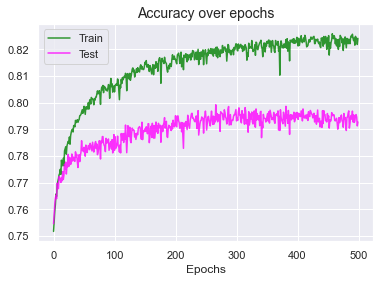

In [28]:
plt.plot(scores_mlp_train, color='green', alpha=0.8, label='Train')
plt.plot(scores_mlp_test, color='magenta', alpha=0.8, label='Test')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

Jak widać, wraz z kolejnymi iteracjami dokładność się zwiększa, jednak dla zbioru testowego rezultaty są gorsze niż dla zbioru treningowego.

Ostatecznie, średnia trafność modelu na rozważanych danych testowych jest następująca.

In [29]:
print(f'Model sieci neuronowej: {nn_clf.score(x_test, y_test)}')

Model sieci neuronowej: 0.7927456907115432


## Regresja logistyczna

Regresja logistyczna to algorytm nadzorowanego uczenia maszynowego używany do problemów z klasyfikacją binarną. Najlepszym sposobem myślenia o regresji logistycznej jest to, że jest to regresja liniowa, ale dla problemów z klasyfikacją. Podstawowa różnica między regresją liniową a regresją logistyczną polega na tym, że zakres regresji logistycznej jest ograniczony od 0 do 1. Ponadto, w przeciwieństwie do regresji liniowej, regresja logistyczna nie wymaga liniowej zależności między zmiennymi wejściowymi i wyjściowymi.

In [30]:
log_model = LogisticRegression(verbose=True, n_jobs=-1, warm_start=True, max_iter=1)

Analogicznie jak poprzednio testujemy model dla 200 iteracji.

In [31]:
scores_log_train = []
scores_log_test = []
for i in range(500):
    log_model.fit(x_train, y_train)
    scores_log_train.append(log_model.score(x_train, y_train))
    scores_log_test.append(log_model.score(x_test, y_test))
    print(f'Iteration {i + 1}, score = {log_model.score(x_test, y_test)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


Iteration 1, score = 0.7297606404705498


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


Iteration 2, score = 0.7373580589821093


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


Iteration 3, score = 0.7499387304958746


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished


Iteration 4, score = 0.7514908912670534


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 5, score = 0.7520627399722245


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 6, score = 0.7549219834980803


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 7, score = 0.7555755248754187


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 8, score = 0.7571276856465975


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 9, score = 0.7554938322032514


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 10, score = 0.7582713830569398


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 11, score = 0.7554938322032514


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 12, score = 0.7576995343517686


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 13, score = 0.755657217547586


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 14, score = 0.7572910709909321


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 15, score = 0.7567192222857609


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 16, score = 0.7578629196961033


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 17, score = 0.7563924515970918


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 18, score = 0.7548402908259129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 19, score = 0.7566375296135937


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 20, score = 0.7561473735805898


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 21, score = 0.7560656809084225


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 22, score = 0.7567192222857609


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 23, score = 0.7559839882362552


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 24, score = 0.7565558369414264


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 25, score = 0.755657217547586


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 26, score = 0.7563924515970918


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 27, score = 0.7555755248754187


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 28, score = 0.7569643003022629


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 29, score = 0.755657217547586


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 30, score = 0.7565558369414264


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 31, score = 0.7554938322032514


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 32, score = 0.7569643003022629


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 33, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 34, score = 0.7570459929744302


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 35, score = 0.7554121395310841


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 36, score = 0.7570459929744302


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 37, score = 0.7548402908259129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished


Iteration 38, score = 0.7572093783187648


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 39, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 40, score = 0.7563924515970918


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 41, score = 0.7549219834980803


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 42, score = 0.7557389102197533


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 43, score = 0.7563924515970918


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 44, score = 0.7555755248754187


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 45, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 46, score = 0.7546769054815783


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 47, score = 0.7550853688424148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 48, score = 0.7548402908259129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 49, score = 0.7550853688424148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 50, score = 0.7550036761702476


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 51, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 52, score = 0.7550036761702476


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 53, score = 0.7550853688424148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 54, score = 0.7548402908259129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 55, score = 0.7550853688424148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 56, score = 0.7546769054815783


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 57, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 58, score = 0.7548402908259129


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 59, score = 0.7550036761702476


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 60, score = 0.7549219834980803


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 61, score = 0.7550036761702476


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 62, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 63, score = 0.7549219834980803


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 64, score = 0.7549219834980803


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 65, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 66, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 67, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 68, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 69, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 70, score = 0.7546769054815783


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 71, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 72, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 73, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 74, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 75, score = 0.7550853688424148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 76, score = 0.7554121395310841


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 77, score = 0.7550853688424148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 78, score = 0.7554121395310841


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 79, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 80, score = 0.7553304468589167


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 81, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


Iteration 82, score = 0.7553304468589167


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 83, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 84, score = 0.7553304468589167


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 85, score = 0.7552487541867494


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 86, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 87, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 88, score = 0.7551670615145821


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 89, score = 0.7550036761702476


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 90, score = 0.7549219834980803


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 91, score = 0.7550853688424148


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 92, score = 0.7546769054815783


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 93, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 94, score = 0.7540233641042399


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 95, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 96, score = 0.7540233641042399


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 97, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 98, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 99, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 100, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 101, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 102, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 103, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 104, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 105, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 106, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 107, score = 0.7540233641042399


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 108, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 109, score = 0.7540233641042399


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 110, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 111, score = 0.7540233641042399


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 112, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 113, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 114, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 115, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 116, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 117, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 118, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 119, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


Iteration 120, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 121, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 122, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 123, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 124, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 125, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 126, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 127, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 128, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 129, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 130, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 131, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 132, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 133, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 134, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 135, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 136, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 137, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 138, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 139, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 140, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


Iteration 141, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 142, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 143, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


Iteration 144, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 145, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 146, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 147, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 148, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 149, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 150, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 151, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 152, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 153, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 154, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 155, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 156, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 157, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 158, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 159, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 160, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 161, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 162, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 163, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 164, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 165, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 166, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 167, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 168, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 169, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 170, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 171, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 172, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 173, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 174, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 175, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 176, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 177, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 178, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 179, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 180, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 181, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 182, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 183, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 184, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 185, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 186, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 187, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 188, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 189, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 190, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 191, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 192, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 193, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 194, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 195, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 196, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 197, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 198, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 199, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 200, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 201, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 202, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 203, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 204, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 205, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 206, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 207, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 208, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 209, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 210, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 211, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 212, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 213, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 214, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 215, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 216, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 217, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 218, score = 0.7541050567764072


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 219, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 220, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 221, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 222, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 223, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 224, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 225, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 226, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 227, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 228, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 229, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 230, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 231, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 232, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 233, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 234, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 235, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 236, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 237, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 238, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 239, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 240, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 241, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


Iteration 242, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 243, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 244, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 245, score = 0.7541867494485744


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 246, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 247, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 248, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 249, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 250, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 251, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 252, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 253, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 254, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 255, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 256, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 257, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 258, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 259, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 260, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 261, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 262, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 263, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 264, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 265, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 266, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 267, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 268, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 269, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 270, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 271, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 272, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 273, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 274, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 275, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 276, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 277, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 278, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 279, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 280, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 281, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 282, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 283, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 284, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 285, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 286, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 287, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 288, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 289, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 290, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 291, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 292, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 293, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 294, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 295, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 296, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 297, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 298, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 299, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 300, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 301, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 302, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 303, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 304, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 305, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 306, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 307, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 308, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 309, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 310, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 311, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 312, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 313, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 314, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 315, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 316, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 317, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 318, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 319, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 320, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 321, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 322, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 323, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 324, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 325, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 326, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 327, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 328, score = 0.7542684421207417


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 329, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 330, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 331, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 332, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 333, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 334, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 335, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 336, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 337, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 338, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 339, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 340, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 341, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 342, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 343, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 344, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 345, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 346, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 347, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 348, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 349, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 350, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 351, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 352, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 353, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 354, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 355, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 356, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 357, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 358, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 359, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 360, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 361, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 362, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 363, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 364, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 365, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 366, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 367, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 368, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 369, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 370, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 371, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 372, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 373, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 374, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 375, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 376, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 377, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 378, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 379, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 380, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 381, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 382, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 383, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 384, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 385, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 386, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 387, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 388, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 389, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 390, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 391, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 392, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 393, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 394, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 395, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 396, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 397, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 398, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 399, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 400, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 401, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 402, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 403, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 404, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 405, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 406, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 407, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 408, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 409, score = 0.7544318274650764


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 410, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 411, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 412, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 413, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 414, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 415, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 416, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 417, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 418, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 419, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 420, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 421, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 422, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 423, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 424, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 425, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 426, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 427, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 428, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 429, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 430, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 431, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 432, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 433, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 434, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 435, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 436, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 437, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 438, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 439, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 440, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 441, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 442, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 443, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 444, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 445, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 446, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 447, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 448, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 449, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


Iteration 450, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 451, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 452, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 453, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 454, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 455, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 456, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 457, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 458, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 459, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 460, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 461, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 462, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 463, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 464, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 465, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 466, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 467, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 468, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 469, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 470, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 471, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 472, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 473, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 474, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 475, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 476, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 477, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 478, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 479, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 480, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 481, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 482, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 483, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 484, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 485, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 486, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 487, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Iteration 488, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 489, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 490, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 491, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 492, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 493, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 494, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 495, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 496, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 497, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 498, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 499, score = 0.754350134792909


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Iteration 500, score = 0.754350134792909


Również tworzymy wykres, jak poprzednio.

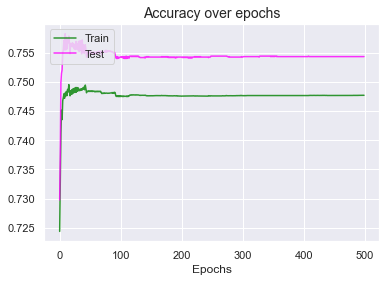

In [32]:
plt.plot(scores_log_train, color='green', alpha=0.8, label='Train')
plt.plot(scores_log_test, color='magenta', alpha=0.8, label='Test')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

Jak widać po niewielkiej liczbie iteracji znajdowane jest dość dobre rozwiązanie, po czym następuje niewielki, lecz gwałtowny spadek jakości rozwiązania, a następnie stopniowo wyrównuje się do wartości uzyskanych przed spadkiem.

Ostatecznie, po wytrenowaniu modelu skuteczność na danych testowych jest następująca:

In [33]:
print(f"Model regresji logistycznej: {log_model.score(x_test, y_test)}")

Model regresji logistycznej: 0.754350134792909


Regresja logistyczna okazała się trochę gorsza od modelu MLP, jednak czas trenowania modelu jest znacząco niższy.

## Optymalizacja hiperparametrów

Powyższe algorytmy MLP i LR posiadają wiele konfigurowalnych hiperparametrów. W przypadku MLP są to m.in. funkcja aktywacji `activation`, przyrost uczenia `learning_rate` oraz `solver`. Dla LR są to m.in. `multi_class` oraz `solver`.
Oczywiście dokładność modeli zależy od wartości tych hiperparametrów. W celu znalezienia kombinacji dającej najlepszej rezultaty posługujemy się biblioteką [optuna](https://optuna.readthedocs.io/en/stable/). Optymalizatory zasadniczo stale zawężają przestrzeń poszukiwań, wykorzystując zapisy sugerowanych wartości parametrów i ocenianych wartości funkcji celu, co prowadzi do optymalnej przestrzeni poszukiwań, w której uzyskuje się parametry prowadzące do lepszych wartości funkcji celu. Domyślnym optymalizatorem jest Tree-structured Parzen Estimator.

### Optymalizacja Multilayer Perceptron

In [ ]:
import optuna
import sklearn.datasets

import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm

def objective(trial):
    activation = trial.suggest_categorical("activation", ["identity", "logistic", "tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["lbfgs", "sgd", "adam"])
    learning_rate_init = trial.suggest_float("lri", 1e-5, 1e-2, log=True)
    learning_rate = "constant"
    if solver == "sgd":
        learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    nn_clf = MLPClassifier(activation=activation, solver=solver, max_iter=500, learning_rate=learning_rate,
                          learning_rate_init=learning_rate_init)
    nn_clf.fit(x_train, y_train)
    return nn_clf.score(x_test, y_test)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 23:23:28,670] A new study created in memory with name: no-name-d5e26172-0593-4457-82e9-6560dd0bd6d9
[I 2022-05-25 23:26:18,592] Trial 0 finished with value: 0.7570459929744302 and parameters: {'activation': 'logistic', 'solver': 'sgd', 'lri': 0.0012386845352251295, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.7570459929744302.
[I 2022-05-25 23:27:54,739] Trial 1 finished with value: 0.7567192222857609 and parameters: {'activation': 'logistic', 'solver': 'sgd', 'lri': 0.0005456039845442819, 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.7570459929744302.


Dla algorytmu MLP najlepsze rezultaty są osiągane dla następujących hiperparametrów: 'activation': 'tanh', 'solver': 'sgd', 'lri': 0.0021175545527070887, 'learning_rate': 'constant'. Skuteczność klasyfikatora wynosi wtedy `0.800`.

Na poniższym wykresie przedstawiono porównanie wcześniejszego modelu wraz z zopymalizowanym modelem.

C:\Users\Piotr\AppData\Local\pypoetry\Cache\virtualenvs\csgo-round-prediction-u_Zhvpzc-py3.10\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


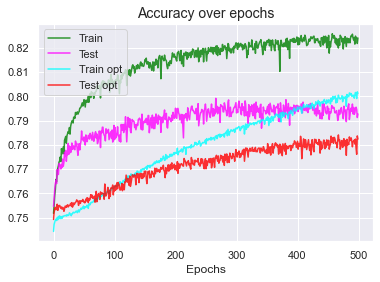

In [34]:
nn_clf_opt = MLPClassifier(warm_start=True, max_iter=1, activation='tanh', solver='sgd',
                           learning_rate='constant', learning_rate_init=0.0021175545527070887)

scores_mlp_train_opt = []
scores_mlp_test_opt = []
for i in range(500):
    nn_clf_opt.fit(x_train, y_train)
    scores_mlp_train_opt.append(nn_clf_opt.score(x_train, y_train))
    scores_mlp_test_opt.append(nn_clf_opt.score(x_test, y_test))

plt.plot(scores_mlp_train, color='green', alpha=0.8, label='Train')
plt.plot(scores_mlp_test, color='magenta', alpha=0.8, label='Test')
plt.plot(scores_mlp_train_opt, color='cyan', alpha=0.8, label='Train opt')
plt.plot(scores_mlp_test_opt, color='red', alpha=0.8, label='Test opt')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

### Optymalizacja Logistic Regression

In [ ]:
import optuna
import sklearn.datasets

import sklearn.ensemble
import sklearn.model_selection
import sklearn.svm

def objective(trial):
    solver = trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear", "sag", "saga"])
    if solver == "newton-cg":
        penalty = trial.suggest_categorical("ncg_pen", ["l2", "none"])
    elif solver == "lbfgs":
        penalty = trial.suggest_categorical("lbfgs_pen", ["l2", "none"])
    elif solver == "liblinear":
        penalty = trial.suggest_categorical("ll_pen", ["l1", "l2"])
    elif solver == "sag":
        penalty = trial.suggest_categorical("sag_pen", ["l2", "none"])
    elif solver == "saga":
        penalty = trial.suggest_categorical("saga_pen", ["elasticnet", "l1", "l2", "none"])
    if solver == "liblinear":
        multi_class = trial.suggest_categorical("multiclass1", ["auto", "ovr"])
    else:
        multi_class = trial.suggest_categorical("multiclass2", ["auto", "ovr", "multinomial"])

    l1_ratio = None
    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1r", 0, 1)
    
    nn_clf = LogisticRegression(solver=solver, max_iter=500, penalty=penalty, multi_class=multi_class, l1_ratio=l1_ratio)
    nn_clf.fit(x_train, y_train)
    return nn_clf.score(x_test, y_test)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

Dla algorytmu LR najlepsze rezultaty są osiągane dla następujących hiperparametrów: 'solver': 'newton-cg', 'penalty': 'l2', 'multi_class': 'ovr'. Skuteczność klasyfikatora wynosi wtedy `0.754`.

W przypadku algorytmu MLP następuje wzrost skuteczności klasyfikatora (`0.784` -> `0.800`). W przypadku LR optymalizacja hiperparametrów nie pomaga - wartość skuteczności zostaje taka sama (`0.754`). Jednak trenowanie LR trwa zauważalnie krócej - ok. 6 sekund, a MLP ok. 8 minut.

In [ ]:
Na poniższym wykresie przedstawiono porównanie wcześniejszego modelu wraz z zopymalizowanym modelem.

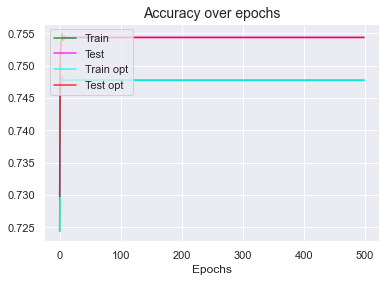

In [35]:
log_model_opt = LogisticRegression(n_jobs=-1, warm_start=True, max_iter=1, multi_class='ovr',
                               solver='newton-cg', penalty='l2')

scores_log_train_opt = []
scores_log_test_opt = []
for i in range(500):
    log_model_opt.fit(x_train, y_train)
    scores_log_train_opt.append(log_model_opt.score(x_train, y_train))
    scores_log_test_opt.append(log_model_opt.score(x_test, y_test))

plt.plot(scores_log_train_opt, color='green', alpha=0.8, label='Train')
plt.plot(scores_log_test_opt, color='magenta', alpha=0.8, label='Test')
plt.plot(scores_log_train_opt, color='cyan', alpha=0.8, label='Train opt')
plt.plot(scores_log_test_opt, color='red', alpha=0.8, label='Test opt')
plt.title("Accuracy over epochs", fontsize=14)
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

## Podział prac

1. ~~Wybór niezbędnych bibliotek - Jakub Michalak~~
1. ~~Walidacja i wydzielenie danych treningowych - Damian Opoka~~
1. ~~Analiza i przygotowanie danych - Damian Opoka~~
1. ~~Definicja modelu - Adam Ryl~~
1. Weryfikacja krzyżowa - Adam Ryl
1. ~~Dostosowanie hiperparametrów - Jakub Michalak~~
1. ~~Wygenerowanie wyników - Piotr Kryczka~~
1. ~~Analiza wyników - Piotr Kryczka~~